# Focus on the images

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import cv2

In [2]:
d = pd.read_csv('./Flipkart/flipkart_com-ecommerce_sample_1050.csv')

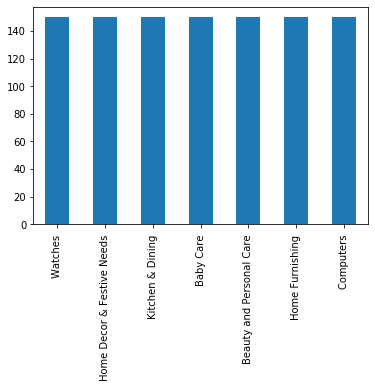

In [3]:
d['main_cat'] = d['product_category_tree'].apply(lambda x: x.split('>>')[0][2::])
d['main_cat'].value_counts().plot.bar()

In [4]:
di = d.loc[:,['product_name','image','main_cat']]
di.head()

,product_name,image,main_cat
0,Elegance Polyester Multicolor Abstract Eyelet ...,55b85ea15a1536d46b7190ad6fff8ce7.jpg,Home Furnishing
1,Sathiyas Cotton Bath Towel,7b72c92c2f6c40268628ec5f14c6d590.jpg,Baby Care
2,Eurospa Cotton Terry Face Towel Set,64d5d4a258243731dc7bbb1eef49ad74.jpg,Baby Care
3,SANTOSH ROYAL FASHION Cotton Printed King size...,d4684dcdc759dd9cdf41504698d737d8.jpg,Home Furnishing
4,Jaipur Print Cotton Floral King sized Double B...,6325b6870c54cd47be6ebfbffa620ec7.jpg,Home Furnishing


# 1. Loading Images

In [5]:
def load_image(file_name):
    file_path = '/'.join(('./Flipkart/Images',file_name))
    return cv2.imread(file_path)

In [6]:
di['img']=di['image'].apply(load_image)

### 1.1 Converting in black and white

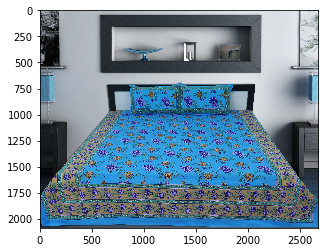

In [10]:
imtest = di.loc[4,'img']
plt.imshow(imtest)

Images are in BGR-format

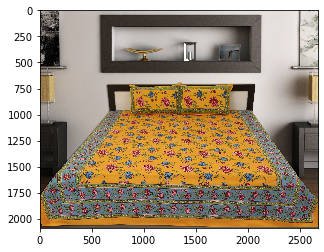

In [11]:
# Displaying the real colors
plt.imshow(cv2.cvtColor(imtest, cv2.COLOR_BGR2RGB))

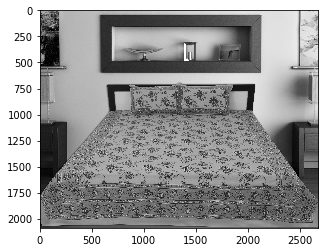

In [12]:
# Displaying the black & white image
img_gray = cv2.cvtColor(imtest, cv2.COLOR_BGR2GRAY)
plt.imshow(img_gray, cmap='gray')

### 1.2 Reshaping

In [7]:
# Resizing to square without distorsion

def resize_to_square(img, size):
    # get image dimensions
    h, w = img.shape[:2]
    
    # dif = max (height, width)
    dif = h if h > w else w
    
    # define interpolation for zooming and shrinkage
    interpolation = cv2.INTER_AREA if dif > size else cv2.INTER_CUBIC    
    
    # for square images
    if h == w: 
        return cv2.resize(img, (size, size), interpolation)
    
    # for non square images
    x_pos = (dif - w)//2
    y_pos = (dif - h)//2
    
    # define mask for both color and back and white images
    if len(img.shape) == 2:
        mask = np.full((dif, dif), 255, dtype=img.dtype)
        mask[y_pos:y_pos+h, x_pos:x_pos+w] = img[:h, :w]
    else:
        mask = np.full((dif, dif, img.shape[2]), 255, dtype=img.dtype)
        mask[y_pos:y_pos+h, x_pos:x_pos+w, :] = img[:h, :w, :]
    
    return cv2.resize(mask, (size, size), interpolation)

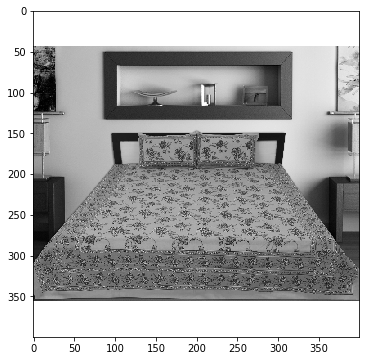

In [13]:
imtest_square = resize_to_square(img_gray, 400)

# display image
plt.figure(figsize=(6,6))
plt.imshow(imtest_square, cmap='gray')
plt.show()

### 1.3 Contrast improvement

In [14]:
clahe = cv2.createCLAHE(clipLimit=1, tileGridSize=(8,8))

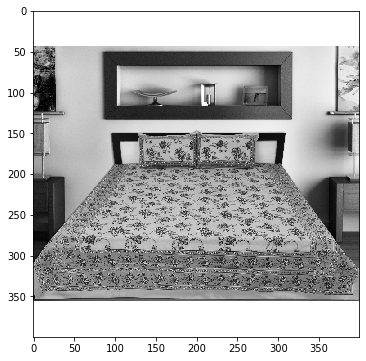

In [15]:
# display image
cl = clahe.apply(imtest_square)
plt.figure(figsize=(6,6))
plt.imshow(cl, cmap='gray')

### 1.4. Complete processing

In [16]:
def traitement_image(img):
    # conversion en noir et blanc
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Redimensionnement
    img_square = resize_to_square(img_gray, 400)
    # Amélioration du contraste
    cl = clahe.apply(img_square)  
    return cl

In [17]:
di['process_img'] = di.loc[:,'img'].apply(traitement_image)

# 2. Features detection with ORB 

In [18]:
orb = cv2.ORB_create(nfeatures = 500)
def get_descriptors(img) :
    kp, des = orb.detectAndCompute(img, None)
    return des

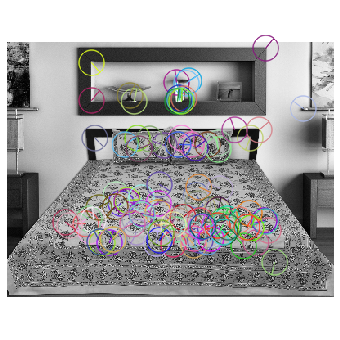

In [19]:
# displaying the features
kp, des = orb.detectAndCompute(di.process_img[4], None)
img2 = cv2.drawKeypoints(di.process_img[4], kp[:100], outImage=None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plt.figure(figsize = (6,6))
plt.imshow(img2)
plt.axis('off')
plt.show()

In [18]:
des.shape

(500, 32)

In [19]:
# Duplicate descriptors ?
list_des = pd.DataFrame(des)
list_des[list_des.duplicated()]

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31


## 2.1 Assignment of descriptors to each image

In [20]:
di['descriptors'] = di.loc[:,'process_img'].apply(get_descriptors)

In [21]:
# Number of descriptors for each image
for index, row in di.iterrows():
    if row['descriptors'] is not None :
        di.at[index,'nb_descriptors'] = len(row['descriptors'])
    else : 
        di.at[index,'nb_descriptors'] = 0

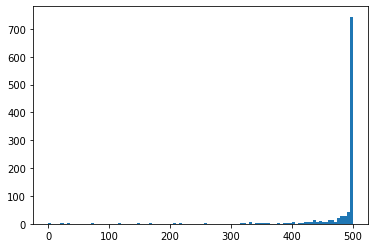

In [22]:
plt.hist(di.nb_descriptors, bins=100)
plt.show()

In [23]:
di['nb_descriptors'].sort_values()[0:10]

343     0.0
354     1.0
862     3.0
835     4.0
893    22.0
843    23.0
838    28.0
859    33.0
327    33.0
850    47.0
Name: nb_descriptors, dtype: float64

Some images have no or few detected features, as for the image below

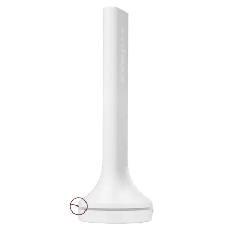

In [22]:
kp, des = orb.detectAndCompute(di.process_img[354], None)
img2 = cv2.drawKeypoints(di.process_img[354], kp, outImage=None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plt.imshow(img2)
plt.axis('off')
plt.show()

## 2.2 Clustering of descriptors

In [24]:
# Aggregate all descriptors before grouping them by similarity
list_descriptors = di.loc[0,'descriptors']

for i in range (1, di.shape[0]):
    if di.loc[i,'descriptors'] is not None :
        list_descriptors = np.vstack((list_descriptors, di.loc[i,'descriptors']))

list_descriptors.shape

(496568, 32)

In [25]:
from sklearn.cluster import MiniBatchKMeans, KMeans
from sklearn.metrics import silhouette_score

In [26]:
n_clusters = 100

model = MiniBatchKMeans(n_clusters=n_clusters, init_size=10000, n_init=10, random_state=2)
model.fit(list_descriptors)

MiniBatchKMeans(batch_size=100, compute_labels=True, init='k-means++',
                init_size=10000, max_iter=100, max_no_improvement=10,
                n_clusters=100, n_init=10, random_state=2,
                reassignment_ratio=0.01, tol=0.0, verbose=0)

## 2.3 Construction of histograms (visual words frequency)

In [27]:
def build_histogram(descriptors):
    histogram = np.zeros(n)
    if descriptors is not None :
        cluster_result =  model.predict(descriptors)
        for i in cluster_result:
            histogram[i] += 1.0
    return histogram

We want to know if the number of visual words selected is decisive for the classification of images. We will therefore create several 'dictionaries' of different sizes (from 100 to 1000 visual words) to evaluate the performance of the algorithms.

In [28]:
n_clusters = [100, 250, 500, 750, 1000]
BovW = {}
for n in n_clusters:
    model = MiniBatchKMeans(n_clusters=n, init_size=10000, n_init=10, random_state=2)
    model.fit(list_descriptors)
    print(n)
    
    hist = di.loc[:, 'descriptors'].apply(build_histogram)
    
    BovW[n] = pd.DataFrame(np.zeros((di.shape[0], n)))
    for index in range(di.shape[0]):
        for i in range(n):
            BovW[n].at[index, i] = hist[index][i]

100
250
500
750
1000


## 2.4 Supervised Classification based on Bags of Visual Words

We will determine the average accuracy by cross validation on the train set for different classification models (Random Forest and Support Vector).

In [71]:
Y = di.loc[:,'main_cat']

In [39]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score

### 2.4.1 Evaluation of models without dimension reduction

### A. Random Forest Classifier

In [96]:
from sklearn.ensemble import RandomForestClassifier
RFC = RandomForestClassifier(n_estimators = 300, random_state = 0)

In [225]:
scores_RF = []
for n in n_clusters:
    X = BovW[n]
    xtrain, xtest, ytrain, ytest = train_test_split(X, Y, train_size=0.8, random_state=0)
    cvscore = cross_val_score(RFC, xtrain, ytrain, scoring='accuracy')
    acc_mean = cvscore.mean().round(3)
    scores_RF.append(acc_mean)
    print('Mean Accuracy for {} visual words : {:.2%}'.format(n,acc_mean))

Mean Accuracy for 100 visual words : 38.10%
Mean Accuracy for 250 visual words : 37.10%
Mean Accuracy for 500 visual words : 38.00%
Mean Accuracy for 750 visual words : 36.10%
Mean Accuracy for 1000 visual words : 35.80%


### B. Support Vector Classification

In [203]:
from sklearn.svm import SVC
svc = SVC()

In [226]:
scores_SVC = []
for n in n_clusters:
    X = BovW[n]
    xtrain, xtest, ytrain, ytest = train_test_split(X, Y, train_size=0.8, random_state=0)
    cvscore = cross_val_score(svc, xtrain, ytrain, scoring='accuracy')
    acc_mean = cvscore.mean().round(3)
    scores_SVC.append(acc_mean)
    print('Mean Accuracy for {} visual words : {:.2%}'.format(n,acc_mean))

Mean Accuracy for 100 visual words : 38.50%
Mean Accuracy for 250 visual words : 41.00%
Mean Accuracy for 500 visual words : 44.80%
Mean Accuracy for 750 visual words : 45.00%
Mean Accuracy for 1000 visual words : 42.40%


### 2.4.2 Dimension reduction through PCA (Principal Component Analysis)

In [30]:
from sklearn import decomposition

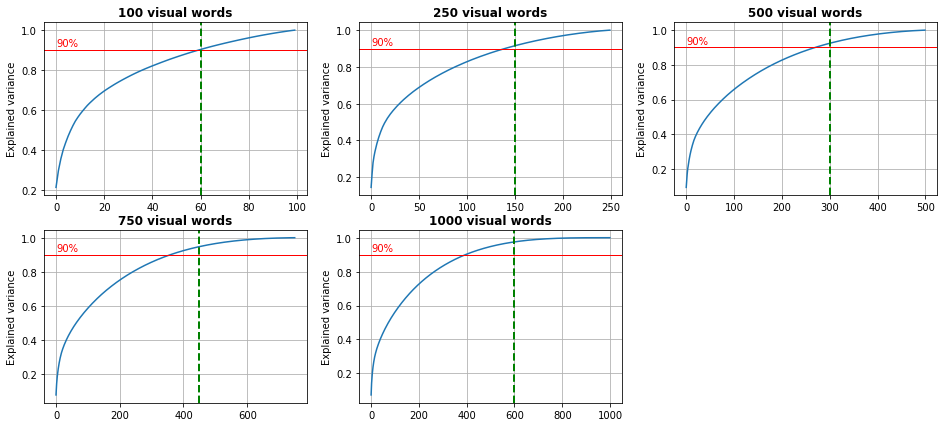

In [31]:
# Number of components

fig = plt.figure(figsize=(16,7))
for i, n in enumerate(n_clusters):
    X = BovW[n]
    pca = decomposition.PCA(n_components=X.shape[1])
    pca.fit(X)
    var_ex_cumsum = pca.explained_variance_ratio_.cumsum()

    ax=fig.add_subplot(2, 3, i+1)
    ax.plot(range(X.shape[1]), var_ex_cumsum)
    ax.axhline(0.9, lw=1, c='red')
    ax.text(0, 0.92, '90%', c='red')
    ax.axvline(n*.6, ls='--', lw=2, c='green')
    ax.set_ylabel('Explained variance')
    ax.set_title('{} visual words'.format(n), fontsize=12, weight='bold')
    ax.grid()
plt.show()

#### By selecting 60% of the components, we conserve at least 90% of the variance.

### A. Random Forest Classifier

In [217]:
scores_RF_PCA = []
for n in n_clusters:
    X = BovW[n]
    pca = decomposition.PCA(n_components=n)
    X_proj = pca.fit_transform(X)
    X_red = X_proj[:,:(int(n*.6))]
    xtrain, xtest, ytrain, ytest = train_test_split(X_red, Y, train_size=0.8, random_state=0)
    cvscore = cross_val_score(RFC, xtrain, ytrain, scoring='accuracy')
    acc_mean = cvscore.mean()
    scores_RF_PCA.append(acc_mean)
    print('Mean Accuracy for {} visual words : {:.2%}'.format(n,acc_mean))

Mean Accuracy for 100 visual words : 39.88%
Mean Accuracy for 250 visual words : 31.19%
Mean Accuracy for 500 visual words : 33.69%
Mean Accuracy for 750 visual words : 34.40%
Mean Accuracy for 1000 visual words : 28.10%


### B. Support Vector Classification

In [218]:
scores_SVC_PCA = []
for n in n_clusters:
    X = BovW[n]
    pca = decomposition.PCA(n_components=n)
    X_proj = pca.fit_transform(X)
    X_red = X_proj[:,:(int(n*.6))]
    xtrain, xtest, ytrain, ytest = train_test_split(X_red, Y, train_size=0.8, random_state=0)
    cvscore = cross_val_score(svc, xtrain, ytrain, scoring='accuracy')
    acc_mean = cvscore.mean().round(3)
    scores_SVC_PCA.append(acc_mean)
    print('Mean Accuracy for {} visual words : {:.2%}'.format(n,acc_mean))

Mean Accuracy for 100 visual words : 39.50%
Mean Accuracy for 250 visual words : 41.10%
Mean Accuracy for 500 visual words : 44.40%
Mean Accuracy for 750 visual words : 44.80%
Mean Accuracy for 1000 visual words : 42.90%


### C. Graphical comparison

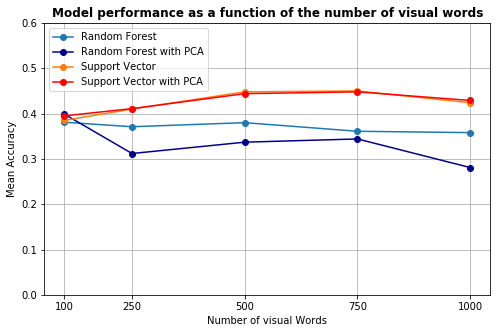

In [227]:
fig,ax = plt.subplots(figsize=(8,5))
ax.plot(n_clusters,scores_RF, marker='o', label='Random Forest')
ax.plot(n_clusters,scores_RF_PCA, marker='o', label='Random Forest with PCA', c='darkblue')
ax.plot(n_clusters,scores_SVC, marker='o', label='Support Vector')
ax.plot(n_clusters,scores_SVC_PCA, marker='o', label='Support Vector with PCA', c='red')
ax.set_title('Model performance as a function of the number of visual words', weight='bold')
ax.set_ylim(0,0.6)
ax.set_ylabel('Mean Accuracy')
ax.set_xlabel('Number of visual Words')
ax.set_xticks(n_clusters)
ax.legend()
ax.grid()
plt.show()

#### Dimension reduction doesn't improve the performance

### Confusion matrix for the best model (SVC with 750 visual words) on test set

In [228]:
X = BovW[750]
xtrain, xtest, ytrain, ytest = train_test_split(X, Y, train_size=0.8, random_state=0)

svc.fit(xtrain, ytrain)
predicted = svc.predict(xtest)
svc.score(xtest, ytest)

0.4714285714285714

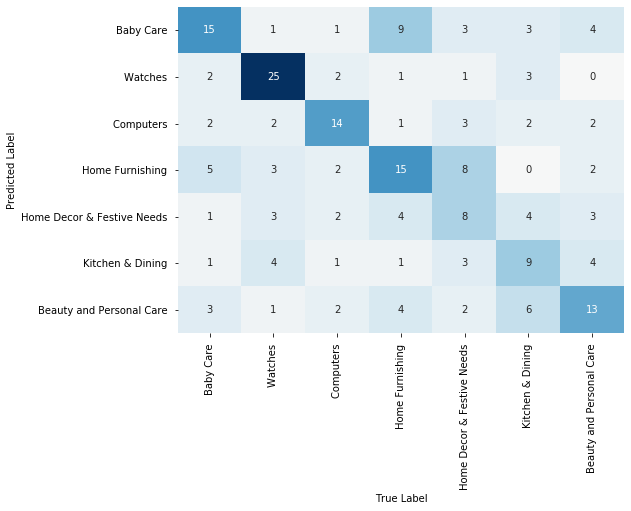

In [233]:
from sklearn.metrics import confusion_matrix
labels = list(set(Y))
cm=confusion_matrix(ytest, predicted, labels=labels)

fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(cm, annot=True, cmap='RdBu', center=0, cbar=False)
ax.set_xticklabels(labels, rotation=90)
ax.set_yticklabels(labels, rotation=0)
ax.set_xlabel('True Label')
ax.set_ylabel('Predicted Label')

plt.show()

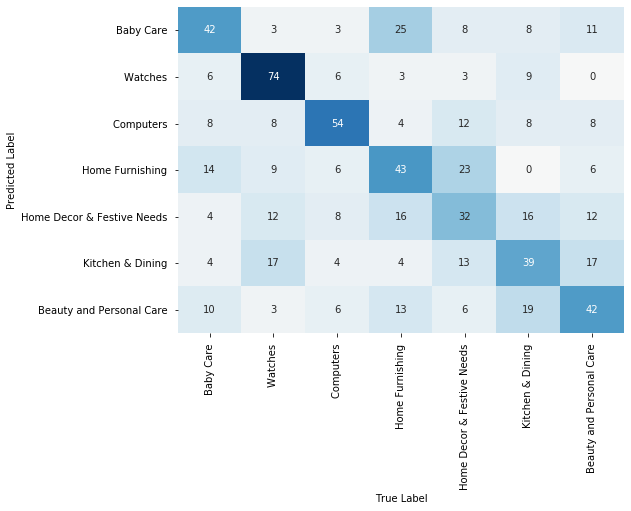

In [232]:
# in percent
cma = pd.DataFrame(cm, index=labels, columns=labels)
for i in labels:
    cma.loc[i] = cma.loc[i].apply(lambda x: 100*x/(cma.loc[i].sum()))
cma=cma.round()

fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(cma, annot=True, cmap='RdBu', center=0, cbar=False)
ax.set_xticklabels(labels, rotation=90)
ax.set_yticklabels(labels, rotation=0)
ax.set_xlabel('True Label')
ax.set_ylabel('Predicted Label')

plt.show()

# 3. Convolutional Neural Networks

## 3.1 Building a simple network to visualize the effect of each layer

In [8]:
from keras.models import Model
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D

Using TensorFlow backend.


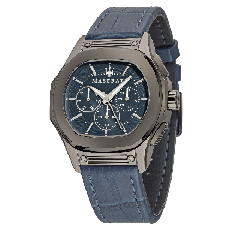

In [8]:
IMG = di.loc[5,'img']
IMG = cv2.cvtColor(IMG, cv2.COLOR_BGR2RGB)
IMG = resize_to_square(IMG, 400)
IMGR = IMG.reshape((1, IMG.shape[0], IMG.shape[1], IMG.shape[2]))
plt.imshow(IMG)
plt.axis('off')
plt.show()

In [10]:
# Convolutional Layer
# keras.layers.Conv2D(filters, kernel_size, strides=(1, 1), padding='valid', activation=None)

# Pooling Layer
# keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid')

In [11]:
model = Sequential()

model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(400, 400, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# redefine model to output after each hidden layer
outputs = [model.layers[i].output for i in range(4)]
model = Model(inputs=model.inputs, outputs=outputs)

In [12]:
feature_maps = model.predict(IMGR)

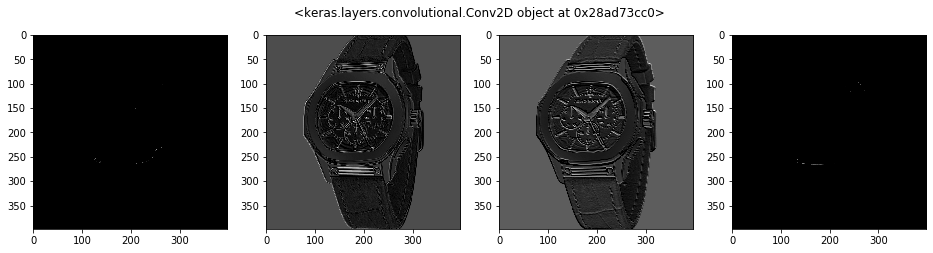

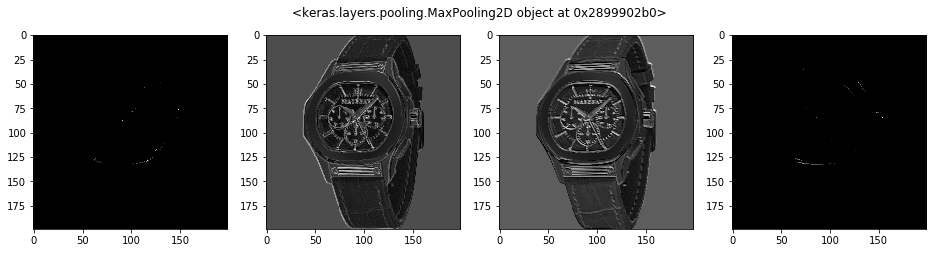

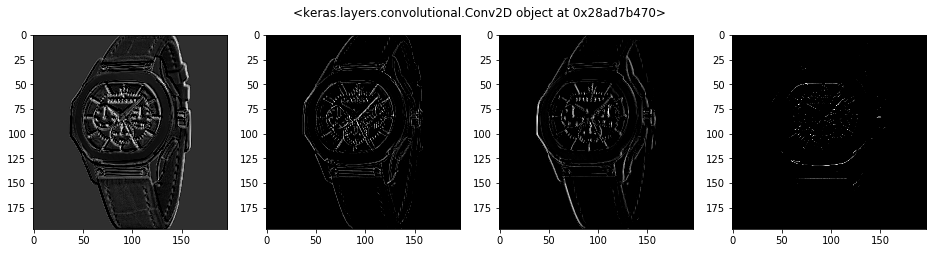

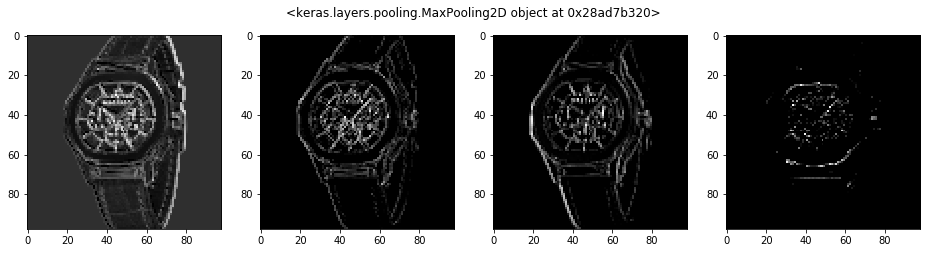

In [13]:
# display the first 4 elements of each feature map
for n,fmap in enumerate(feature_maps):
    fig=plt.figure(figsize=(16,4))
    plt.title(model.layers[n+1])
    plt.axis('off')
    for i in range(4):
        ax=fig.add_subplot(1,4,i+1)
        #ax.set_xticks([])
        #ax.set_yticks([])
        plt.imshow(fmap[0, :, :, i], cmap='gray')
    plt.show()

## 3.2 Transfer learning using a pre-trained CNN

In [9]:
from keras.applications.vgg16 import VGG16

model = VGG16() # Using the VGG-16 model implemented by Keras

### 3.2.1 Preprocessing the input

The input should be a RGB image with a 224  × 224 px size

In [10]:
from keras.applications.vgg16 import preprocess_input

In [11]:
def traitement_image_VGG16(img):
    # convert to RGB
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Resizing
    img = resize_to_square(img, 224)
    img = img.reshape((1, img.shape[0], img.shape[1], img.shape[2]))
    
    # Apply the pre-defined preprocessing for VGG16
    img = preprocess_input(img)
    return img

In [12]:
di['process_VGG16'] = di.loc[:,'img'].apply(traitement_image_VGG16)

### 3.2.3 Building the input and output matrices

In [13]:
X = di['process_VGG16'].loc[0]
for row in di['process_VGG16'][1:]:
    X = np.concatenate((X,row), axis=0)
X.shape

(1050, 224, 224, 3)

In [20]:
# Encoding of the output categories
Y = pd.get_dummies(di['main_cat'])
Y.shape

(1050, 7)

In [28]:
# Splitting train and test set
from sklearn.model_selection import train_test_split
xtrain, xtest, ytrain, ytest = train_test_split(X, Y, train_size=0.8, random_state=0)

### 3.2.4 Building the model

In [26]:
from keras import optimizers
optimizer=optimizers.SGD(lr=0.0001, momentum=0.9)

# Load the on ImageNet pre-trained VGG-16 without the fully-connected layers
base_model = VGG16(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

# We don't re-train all the layers (transfer learning)
for layer in base_model.layers:
    layer.trainable = False

# Collect the output and transform it into a vector
x = base_model.output
x = Flatten()(x)

# Add the fully-connected layer for the classification in 7 categories
predictions = Dense(7, activation='softmax')(x)

# Define the new model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model 
model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

In [27]:
model.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

### 3.2.5 Model Training with validation split

In [29]:
# We'll stop the training as soon as the accuracy on the validation split no longer improves
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_accuracy', patience=2, restore_best_weights=True)

In [30]:
model.fit(xtrain, ytrain, epochs=20, batch_size=135, validation_split=0.2, verbose=1, callbacks=[early_stopping])

Train on 672 samples, validate on 168 samples
Epoch 1/20
672/672 [==============================] - 594s 884ms/step - loss: 13.9750 - accuracy: 0.3318 - val_loss: 7.1512 - val_accuracy: 0.6250
Epoch 2/20
672/672 [==============================] - 592s 880ms/step - loss: 3.5070 - accuracy: 0.7693 - val_loss: 7.3037 - val_accuracy: 0.7321
Epoch 3/20
672/672 [==============================] - 759s 1s/step - loss: 1.7281 - accuracy: 0.8899 - val_loss: 8.1718 - val_accuracy: 0.7440
Epoch 4/20
672/672 [==============================] - 1206s 2s/step - loss: 0.7443 - accuracy: 0.9375 - val_loss: 7.8893 - val_accuracy: 0.7798
Epoch 5/20
672/672 [==============================] - 667s 992ms/step - loss: 0.2463 - accuracy: 0.9732 - val_loss: 7.6235 - val_accuracy: 0.7857
Epoch 6/20
672/672 [==============================] - 615s 915ms/step - loss: 0.0911 - accuracy: 0.9866 - val_loss: 7.7021 - val_accuracy: 0.7798
Epoch 7/20
672/672 [==============================] - 587s 874ms/step - loss: 0.01

#### After training, we obtain an accuracy of 78.6% on the validation set.

In [33]:
# Get the history for validation loss / accuracy
# hist = model.fit(x, y, validation_split=0.2)
# print(hist.history)

In [31]:
# Score on the test set
model.evaluate(xtest, ytest) 

210/210 [==============================] - 141s 672ms/step


[5.942676648639497, 0.7523809671401978]

In [32]:
model.save_weights('vgg16_075.h5')

In [45]:
# model.load_weights('vgg16_075.h5')

### 3.2.6 Visualizing the performances on the test set : Confusion Matrix

In [34]:
predicted = pd.DataFrame(model.predict(xtest), index=ytest.index, columns=ytest.columns)
lab_pred = predicted.idxmax(axis=1)
lab_true = ytest.idxmax(axis=1)
listcat = ytest.columns.tolist()

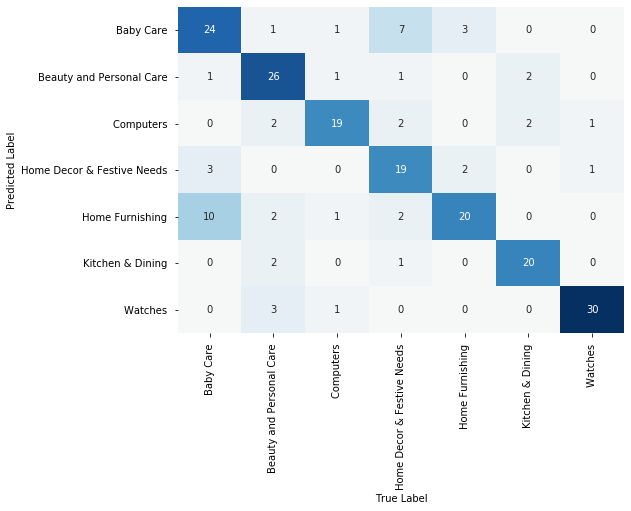

In [35]:
from sklearn.metrics import confusion_matrix
cm=confusion_matrix(lab_true, lab_pred, labels=listcat)

fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(cm, annot=True, cmap='RdBu', center=0, cbar=False)
ax.set_xticklabels(listcat, rotation=90)
ax.set_yticklabels(listcat, rotation=0)
ax.set_xlabel('True Label')
ax.set_ylabel('Predicted Label')

plt.show()

#### Conclusion : the classification performs much better with this method. 
#### We are now going to study the feasibility to automatically classify the images from the features learned by the network.

## 3.3 Using a pre-trained CNN for feature extraction

In [23]:
base_model = VGG16(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

x = base_model.output
x = Flatten()(x)

f_model = Model(inputs=base_model.input, outputs=x)

# Display the structure of the network
f_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [24]:
features = pd.DataFrame(f_model.predict(X))

In [29]:
features.to_csv('features_img.csv', index=0)

In [31]:
features.shape

(1050, 25088)

In [4]:
features = pd.read_csv('features_img.csv')

### 3.3.1 Clustering of extracted features

We first reduce the dimension with a PCA

In [5]:
from sklearn import decomposition
pca = decomposition.PCA()
pca.fit(features)
features_proj = pca.transform(features)

### Projection in two dimensions (t-SNE)

In [17]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=1)
tsne_results = tsne.fit_transform(features_proj)

In [18]:
tsnecat = pd.concat((pd.DataFrame(tsne_results),d['main_cat']), axis= 1)

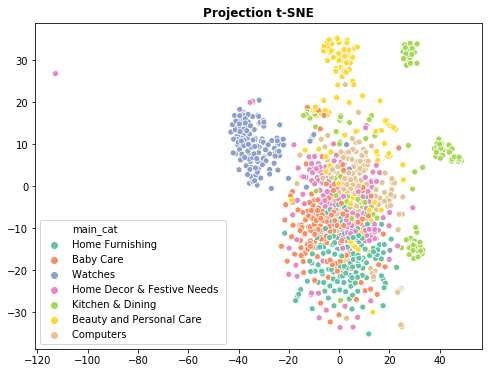

In [19]:
fig, ax = plt.subplots(figsize=(8,6))
sns.scatterplot(x=0, y=1, hue='main_cat', data=tsnecat, palette=sns.color_palette("Set2", 7), legend='full')
ax.set_title('Projection t-SNE', fontsize=12, weight='bold')
ax.set_xlabel('')
ax.set_ylabel('')
plt.show()

### A) K-Means

In [6]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [20]:
# Recherche du meilleur nbre de clusters
silhouettes = []

for n_cluster in range(4, 10):
    cls = KMeans(n_clusters=n_cluster, n_init=50, random_state=7)
    cls.fit(features_proj)
    silhouettes.append(silhouette_score(features_proj, cls.labels_))

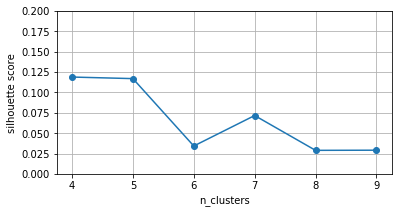

In [21]:
fig, ax = plt.subplots(figsize=(6, 3))

ax.plot(range(4, 10), silhouettes, marker='o')
ax.set_ylim(0, 0.2)
ax.set_xticks(range(4, 10))
ax.set_xlabel('n_clusters')
ax.set_ylabel('silhouette score')
ax.grid()
plt.show()

In [22]:
kmeans = KMeans(n_clusters=4, n_init=50, random_state=7)
kmeans.fit(features_proj)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=4, n_init=50, n_jobs=None, precompute_distances='auto',
       random_state=7, tol=0.0001, verbose=0)

In [24]:
round(silhouette_score(features_proj, kmeans.labels_),2)

0.12

### Displaying the clusters on the t-SNE projection

In [25]:
tsnekm = np.column_stack((tsne_results, kmeans.labels_.astype(int)))
tsnekmdf = pd.DataFrame(tsnekm, columns = [0,1,'kmeans_label'])

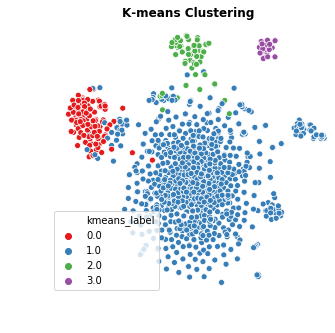

In [51]:
fig, ax = plt.subplots(figsize=(5,5))
sns.scatterplot(x=0, y=1, hue='kmeans_label', data=tsnekmdf, palette=sns.color_palette("Set1", 4), legend='full')
ax.set_title('K-means Clustering', fontsize=12, weight='bold')
ax.set_xlim(-50,50)
#ax.get_legend().set_visible(False)
plt.axis('off')
plt.show()

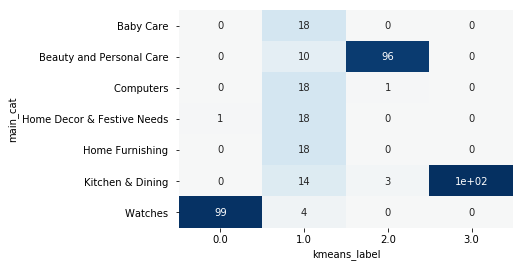

In [32]:
# Distribution of products in each cluster
plt.figure(figsize=(6,4))
crosstab = pd.crosstab(d['main_cat'], tsnekmdf['kmeans_label'], normalize='columns')*100
sns.heatmap(crosstab.round(), annot=True, cmap='RdBu', center=0, cbar=False)
plt.show()

In [31]:
# Proportion of products in each cluster
pd.Series(kmeans.labels_).value_counts()/10.50

1    79.142857
0    11.047619
2     6.857143
3     2.952381
dtype: float64

### B) Gaussian Mixture Model

In [33]:
from sklearn import mixture

In [34]:
# Search for the best model
lowest_bic = np.infty
bic = []
n_components_range = range(4, 10)
cv_types = ['spherical', 'tied', 'diag', 'full']
for cv_type in cv_types:
    for n_components in n_components_range:
        gmm = mixture.GaussianMixture(n_components=n_components,
                                      covariance_type=cv_type, reg_covar = 0.1)
        gmm.fit(features_proj)
        bic.append(gmm.bic(features_proj))
        if bic[-1] < lowest_bic:
            lowest_bic = bic[-1]
            best_gmm = gmm

In [35]:
best_gmm.fit(features_proj)

GaussianMixture(covariance_type='diag', init_params='kmeans', max_iter=100,
                means_init=None, n_components=6, n_init=1, precisions_init=None,
                random_state=None, reg_covar=0.1, tol=0.001, verbose=0,
                verbose_interval=10, warm_start=False, weights_init=None)

In [36]:
gmm_labels = best_gmm.predict(features_proj)

In [37]:
round(silhouette_score(features_proj, gmm_labels),2)

-0.08

### Displaying the clusters on the t-SNE projection

In [38]:
tsneg = np.column_stack((tsne_results, gmm_labels))
tsnegdf = pd.DataFrame(tsneg, columns = [0,1,'GMM_label'])

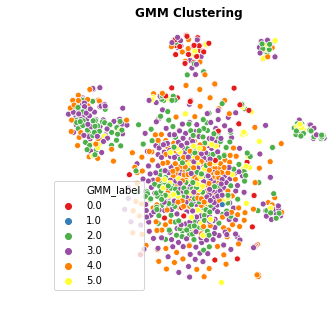

In [42]:
fig, ax = plt.subplots(figsize=(5,5))
sns.scatterplot(x=0, y=1, hue='GMM_label', data=tsnegdf, palette=sns.color_palette("Set1", 6), legend='full')
ax.set_title('GMM Clustering', fontsize=12, weight='bold')
ax.set_xlim(-50,50)
#ax.get_legend().set_visible(False)
plt.axis('off')
plt.show()

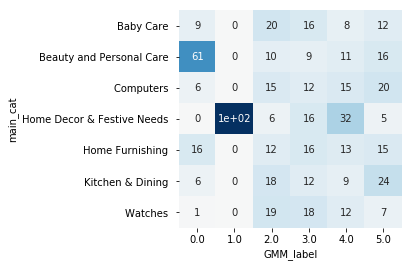

In [41]:
# Distribution of products in each cluster
plt.figure(figsize=(4,4))
crosstab = pd.crosstab(d['main_cat'], tsnegdf['GMM_label'], normalize='columns')*100
sns.heatmap(crosstab.round(), annot=True, cmap='RdBu', center=0, cbar=False)
plt.show()

In [43]:
# proportion of products in each cluster
pd.Series(gmm_labels).value_counts()/10.50

3    31.047619
2    25.428571
4    21.428571
5    15.619048
0     6.380952
1     0.095238
dtype: float64

### C) DB Scan

In [7]:
from sklearn.cluster import DBSCAN

In [8]:
# Search for the optimal distance
N_clusters = []
Noise = []
Sil_score = []

ran = np.arange(1000, 2000, 100)

for dist in ran :
    db = DBSCAN(eps=dist, min_samples=10, algorithm='kd_tree', n_jobs=-1)
    db.fit(features_proj)
    n_clusters_ = len(set(db.labels_)) - (1 if -1 in db.labels_ else 0)
    n_noise_ = list(db.labels_).count(-1)
    N_clusters.append(n_clusters_)
    Noise.append(n_noise_/features_proj.shape[0])
    Sil_score.append((silhouette_score(features_proj, db.labels_)
                      if n_clusters_ > 1 else 0))

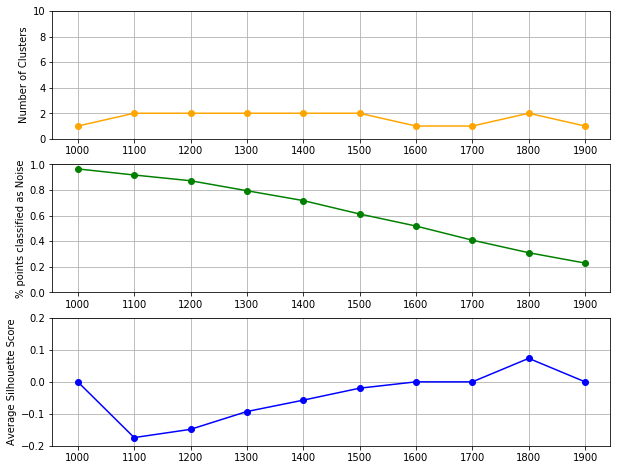

In [9]:
fig, ax = plt.subplots(3, 1, figsize=(10, 8))
ax[0].plot(ran, N_clusters, marker='o', c='orange')
ax[1].plot(ran, Noise, marker='o', c='green')
ax[2].plot(ran, Sil_score, marker='o', c='blue')

for i in range(3):
    ax[i].set_xticks(ran)
    ax[i].grid()
ax[0].set_ylim(0, 10)
ax[0].set_ylabel('Number of Clusters')
ax[1].set_ylim(0, 1)
ax[1].set_ylabel('% points classified as Noise')
ax[2].set_ylim(-0.2, 0.2)
ax[2].set_ylabel('Average Silhouette Score')
plt.show()

In [44]:
dbs = DBSCAN(eps=1800, min_samples=10, algorithm='kd_tree', n_jobs=-1)
dbs.fit(features_proj)

DBSCAN(algorithm='kd_tree', eps=1800, leaf_size=30, metric='euclidean',
       metric_params=None, min_samples=10, n_jobs=-1, p=None)

In [47]:
round(silhouette_score(features_proj, dbs.labels_),2)

0.07

In [45]:
tsnedb = np.column_stack((tsne_results, dbs.labels_))
tsnedbdf = pd.DataFrame(tsnedb, columns = [0,1,'DB_label'])

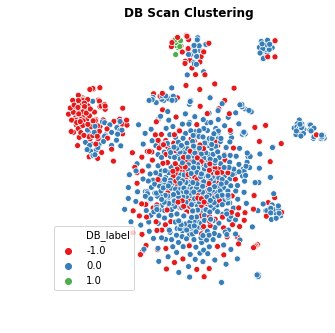

In [50]:
fig, ax = plt.subplots(figsize=(5,5))
sns.scatterplot(x=0, y=1, hue='DB_label', data=tsnedbdf, palette=sns.color_palette("Set1", 3), legend='full')
ax.set_title('DB Scan Clustering', fontsize=12, weight='bold')
ax.set_xlim(-50,50)
#ax.get_legend().set_visible(False)
plt.axis('off')
plt.show()

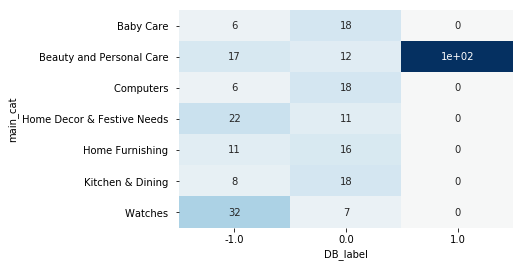

In [49]:
# Distribution of products in each cluster
crosstab = pd.crosstab(d['main_cat'], tsnedbdf['DB_label'], normalize='columns')*100
sns.heatmap(crosstab.round(), annot=True, cmap='RdBu', center=0, cbar=False)
plt.show()

#### Conclusion : K-Means clustering is performing the best, but the segmentation is still very imperfect.